# Information retrieval Hw4
امتیازی ها پیاده سازی شده است.

In [1]:
import heapq
import os
import string
import re
from typing import List
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1006)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1006)>


False

## Utility functions

In [3]:
def read_documents(path=os.getcwd()):
    documents = []
    with open(path) as f:
        articles = f.read().split('\n.I')
        for i, article in enumerate(articles):
            article = article.split('\n.T\n')[1]
            T, _, article = article.partition('\n.A\n')
            A, _, article = article.partition('\n.B\n')
            B, _, W = article.partition('\n.W\n')
            curr_doc = Documents(index=i + 1, title=T, author=A, detail=B, text=W)
            documents.append(curr_doc)
        collection_size = len(articles)
    return documents, collection_size


def read_queries(X_path, y_path, n):
    with open(X_path, 'r') as query_file:
        queries = query_file.read().split('\n.I')
        query_list = []
        for i, query in enumerate(queries):
            query = query.split('\n')
            query_list.append(' '.join(query[2:]))
    with open(y_path, 'r') as result_file:
        lines = result_file.readlines()
        results = [[] for i in range(n)]
        for line in lines:
            query_idx, document, relevancy = line.split()
            if int(relevancy) > 0:
                results[int(query_idx) - 1].append(int(document))
    return query_list, results


## Custom dataset class

In [4]:
class Documents:
    """
    In this class, I implement a document object, which store attributes of a documents such as title, author, detail and text.
    ...
    Attributes:
    ----------
    title: str
        title of a document
    author: str
        author of a document
    detail: str
        detail of a document(.B in file)
    text: str | list
        text of a document which represent as a string but list after tokenizing
    """
    def __init__(self, index, title, author, detail, text):
        self.index: str = index
        self.title: str = title
        self.author: str = author
        self.detail: str = detail
        self.text: str | list = text

    def __str__(self):
        return f"title: {self.title}\nauthor: {self.author}\ndetail: {self.detail}text: \n{self.text}\n"

    def __repr__(self):
        return f"title: {self.title}\nauthor: {self.author}\ndetail: {self.detail}text: \n{self.text}\n"


## Preprocessors

In [5]:
stop_words = set(nltk.corpus.stopwords.words('english'))
def preprocess_text(text):
    """
    Preprocesses the text by tokenizing, converting to lowercase, removing punctuation,
    and filtering out stop words.
    """
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    tokens = nltk.tokenize.word_tokenize(text)
    # Filter out stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

def preprocess_documents(documents):
    """
    Apply text preprocessing to each document in the dictionary.
    """
    preprocessed_docs = []
    for doc_id, document in enumerate(documents):
        preprocessed_text = preprocess_text(document.text)
        document.text = preprocessed_text
        preprocessed_docs.append(document)
    return preprocessed_docs


## Inverted Index model

In [6]:
class Term:
    """
    In this class, I implement a term object, which store the valuse of a term(str), the list of documents that it is
    occurred in, and its index in them, the cf and df.
    ...
    Attributes:
    ----------
    word: str
        value of a token
    docs: list[dict]
        list of documents that it is occurred in, and its index in them. Each document is represented as a dict with doc_idx as key(index of the document) and
        a list of indexes as value( list of index of the occurrence of the token in this document)
    """
    def __init__(self, word: str):
        self.word: str = word
        self.docs: list[dict] = []
        self.df: int = 0
        self.cf: int = 0

    def __str__(self):
        return self.word

    def __repr__(self):
        return self.word

In [7]:
class InvertedIndex:
    """
    In this class, I implement an information retrieval system which can search a query among documents.
    ...
    Attributes:
    -----------
    collection_size: int
        number of documents.
    documents: List
        list of documents in format of Document object.
    posting_list: List[Token]
        list of Term objects. Terms store a string , document's indexes , cf and df
    tf_idf_matrix: List[List] (matrix)
        The tf-idf matrix that described in the slides.


    Methods
    -------
    Methods defined here:
        __init__(self, documents: List, case_sensitive=False):
            Constructor will set initial attributes like case_sensitivity. NOTE that documents should be read with
            read_document function after creating our IR system.
            :parameter
            ---------
            :return
                None

        get_token_index(self, x):
            this function finds index of a word in posting list using binary search algorithm.
            :parameter
                x:str
                    the word you want to find its index
            :return
                int: index of the word in posting_list

        create_posting_list(self):
            calling this function, will create posting list of all occurred words cross all documents.
            :parameter
                None
            :return
                None

        create_tf_idf_matrix(self):
            This function will create a tf-idf matrix. I used the formula in the slides.
            :parameter
                None
            :return
                None
    """

    def __init__(self, documents, collection_size):
        self.collection_size: int = collection_size
        self.documents: list[Documents] = documents
        self.tf_idf_matrix = []
        self.posting_list: List[Term] = []

    def get_term_index(self, term):
        """
        This function find index of a word in posting list using binary search algorithm.
            :parameter
                x:str
                    the word you want to find its index
            :return
                int: index of the word in posting_list
        """
        low = idx = 0
        high = len(self.posting_list) - 1
        while low <= high:
            if high - low < 2:
                if self.posting_list[high].word < term:
                    idx = high + 1
                    break
                elif self.posting_list[high].word == term:
                    idx = high
                    break
                elif self.posting_list[low].word >= term:
                    idx = low
                    break
            idx = (high + low) // 2
            if self.posting_list[idx].word < term:
                low = idx + 1
            elif self.posting_list[idx].word > term:
                high = idx - 1
            else:
                break
        return idx

    def create_posting_list(self):
        """
        calling this function, will create posting list of all occurred words cross all documents. in this function, I
        loop over all documents, then inside this loop, I loop over all the tokens that are in the current document.
        then I check if the length of posting_list is zero, then I add this token as first term. else if the length of
        posting_list is more than 0, I find the correct index of the token in posting_list alphabetically. then I check
        if this token, has been already in posting_list, I just add the current document index in tokens.docs, else, I
        add this token in the posting_list, then add the current document index. I also calculate cf and df during the loops.
            :parameter
                None
            :return
                None
        :return:
        """
        for doc_idx, doc in enumerate(self.documents):
            for token_idx, token in enumerate(doc.text):
                if len(self.posting_list) == 0:
                    self.posting_list.append(Term(token))
                    self.posting_list[0].docs.append({doc_idx: [token_idx]})
                    self.posting_list[0].cf += 1
                    continue

                idx = self.get_term_index(token)

                if idx == len(self.posting_list):
                    self.posting_list.append(Term(token))
                    # self.posting_list[i].post_idx.append(post_idx)
                elif token != self.posting_list[idx].word:
                    self.posting_list.insert(idx, Term(token))

                if len(self.posting_list[idx].docs) == 0:
                    self.posting_list[idx].docs.append({doc_idx: [token_idx]})
                    self.posting_list[idx].df += 1
                elif doc_idx not in self.posting_list[idx].docs[-1].keys():
                    self.posting_list[idx].docs.append({doc_idx: [token_idx]})
                    self.posting_list[idx].df += 1
                else:
                    self.posting_list[idx].docs[-1][doc_idx].append(token_idx)
                self.posting_list[idx].cf += 1

    def idf(self, df_t):
        return np.log(self.collection_size / df_t)

    def create_tf_idf_matrix(self):
        """
        This function will create a tf-idf matrix. I used the formula in the slides. Fisrt I set all values of the matrix to zeros then I loop over all terms in posting list and then loop over all documents in each term, an set the row of t-th term and doc_idx-th column to tf*idf.
        :return:
            None
        """
        self.tf_idf_matrix = np.zeros([len(self.posting_list), len(self.documents)])
        for t in range(len(self.posting_list)):
            for doc in self.posting_list[t].docs:
                doc_idx, indexes = next(iter(doc.items()))
                self.tf_idf_matrix[t, doc_idx] = len(doc[doc_idx]) * np.log(
                    self.collection_size / self.posting_list[t].df)

        for col_idx in range(len(self.documents)):
            v_norm = np.linalg.norm(self.tf_idf_matrix[:, col_idx])
            if v_norm != 0:
                self.tf_idf_matrix[:, col_idx] = self.tf_idf_matrix[:, col_idx] / v_norm


## Ranking models

In [8]:
class BaseRankingModel:
    """
        vectorize_query(self, query):
        This function gets a query and create a correspond vector for this query.
        :parameter
            query: str
                The query that you want to vectorize it.
        :return
            np.array
                The vectorized query

    """

    def __init__(self, inverted_index):
        self.inverted_index = inverted_index

    def vectorize_query(self, query):
        """
            This function gets a query and create a correspond vector for this query. I create a vector with length of
            posting list and set all values to zero. The I loop over all terms in my posting list then if this term has
            been occured in query, I set the t-th entry to tf*idf.
            :parameter
                query: str
                    The query that you want to vectorize it.
            :return
                np.array
                    The vectorized query

        """
        preprocessed_query = preprocess_text(query)
        vector = np.zeros(len(self.inverted_index.posting_list))
        for t in range(len(self.inverted_index.posting_list)):
            tf = preprocessed_query.count(self.inverted_index.posting_list[t].word)
            idf = np.log(self.inverted_index.collection_size / self.inverted_index.posting_list[t].df)
            vector[t] = tf * idf
        return vector

    def compute_rankings(self, **kwargs):
        raise NotImplementedError("Subclasses must override this method.")


class CosineScore(BaseRankingModel):
    def compute_rankings(self, query, k_top):
        """
        This function perform cosine similarity scoring for the given query and return top k relevant documents. I do
        the same algorithm that descirbed in slides.
            :parameter
                query: str
                    The query that you want to get relevant documents
                k_top:int
                    top k relevant documents
            :return
                top k relevant documents to given query
        """
        scores = [[0, i + 1] for i in range(len(self.inverted_index.documents))]
        vectorized_query = self.vectorize_query(query)
        for col_idx in range(len(self.inverted_index.documents)):
            scores[col_idx][0] = -1 * np.inner(vectorized_query, self.inverted_index.tf_idf_matrix[:, col_idx])

        heapq.heapify(scores)
        results = []
        for _ in range(k_top):
            score, idx = heapq.heappop(scores)
            results.append([-1 * score, idx])
        # scores.sort(key=lambda x: x[1], reverse=True)
        # results = scores[0:5]
        return results


class OkapiBM25(BaseRankingModel):
    def compute_rankings(self, query, k_top, k1, k3, b, method='basic', long_length=10):
        """
        This function perform Okapi BM25 scoring for the given query and tune parameters and return top k relevant
        documents. First I create a list of 2-tuples with length of all documents to score each documents according to
        the query and set their score to zero. Then I do the exact algorithm in the slides and set the variables. And I
        loop over all documents and calculate the formula that provided in slides, then save them in the correspond
        index in RSV_List.
        :parameter
            query: str
                The query that you want to get relevant documents.
            k_top: int
                Number of most relevant documents
            long_length: int
                bound for length of the query that determine if the query is long or not.
        """
        RSV_list = [[0, i + 1] for i in range(len(self.inverted_index.documents))]
        preprocessed_query = preprocess_text(query)
        N = self.inverted_index.collection_size
        L_avg = np.mean([len(document.text) for document in self.inverted_index.documents])
        L_q = len(query)

        for doc_idx, document in enumerate(self.inverted_index.documents):
            L_d = len(document.text)
            for term in preprocessed_query:
                t = self.inverted_index.get_term_index(term)
                if self.inverted_index.posting_list[t].word == term:
                    tf = document.text.count(term)
                    df = self.inverted_index.posting_list[t].df
                    temp = (np.log(N / df) * (k1 + 1) * tf) / \
                           (k1 * ((1 - b) + b * (L_d / L_avg)) + tf)
                    if L_q >= long_length and method == 'long':
                        temp *= ((k3 + 1) * tf) / (k3 + tf)
                    RSV_list[doc_idx][0] -= temp  # The minus is for using Max-heap

        heapq.heapify(RSV_list)
        results = []
        for _ in range(k_top):
            RSV, idx = heapq.heappop(RSV_list)
            results.append([-1 * RSV, idx])
        return results


class LanguageModel(BaseRankingModel):
    def compute_rankings(self, query, k_top, lambd):
        """
        This function perform a language model scoring for the given query and tune parameters and return top k
        relevant documents. First I create a list of 2-tuples with length of all documents to score each documents
        according to the query and set their score to zero. Then I do the exact algorithm in the slides and set the
        variables. And I loop over all documents and calculate the formula that provided in slides, then save them in
        the correspond index in document_probs.
        """
        document_probs = [[0, i + 1] for i in range(len(self.inverted_index.documents))]
        preprocessed_query = preprocess_text(query)
        T = 0
        for term in self.inverted_index.posting_list:
            T += term.cf

        for doc_idx, document in enumerate(self.inverted_index.documents):
            L_d = len(document.text)
            for i, term in enumerate(preprocessed_query):
                t = self.inverted_index.get_term_index(term)
                tf = document.text.count(term)
                P_t_M_d = tf / (L_d or 1)
                P_t_M_c = self.inverted_index.posting_list[t].cf / T
                P_t_d = lambd * (P_t_M_d) + (1 - lambd) * (P_t_M_c)
                if i == 0:
                    document_probs[doc_idx][0] = P_t_d
                else:
                    document_probs[doc_idx][0] *= P_t_d

        document_probs = [[-prob, i] for prob, i in document_probs]
        heapq.heapify(document_probs)
        results = []
        for _ in range(k_top):
            prob, idx = heapq.heappop(document_probs)
            results.append([-1 * prob, idx])
        return results


## Evaluation functions

In [9]:
def eval_11_point_interpolation(y_orig, predicted):
    """
    This function calculate the 11-point interpolated average precision. it gets a list of actual relevant
    documents and a list of predicted documents that model returned. Then compute the 11-point interpolated
    average precision.
    :parameter
        y_orig: list
            list of actual relevant documents to a query
        predicted: list
            list of predicted documents that model returned
    :return
        11-point interpolated average precision
    """
    precision = []
    recall = []
    relevant = 0

    for pred in predicted:
        if pred in y_orig:
            relevant += 1
    if relevant == 0:
        relevant = 1
    seen_relevant = 0
    for i, pred in enumerate(predicted):
        if pred in y_orig:
            seen_relevant += 1
        precision.append(seen_relevant / (i + 1))
        recall.append(seen_relevant / relevant)

    interpolated_precision = np.zeros(11)
    for i in range(len(predicted) - 1, -1, -1):
        j = 0
        while j <= recall[i] * 10:
            if interpolated_precision[j] < precision[i]:
                interpolated_precision[j] = precision[i]
                j += 1
            else:
                break
    return interpolated_precision

## Reading datasets

In [10]:
documents, collection_size = read_documents(path='../dataset/raw/cran.all.1400')
query_list, relevant_list = read_queries(X_path='../dataset/raw/cran.qry', y_path='../dataset/raw/cranqrel', n=225)

#### Preprocess our datasets

In [11]:
preprocessed_documents = preprocess_documents(documents)

In [12]:
inverted_index = InvertedIndex(documents=preprocessed_documents,
                               collection_size=collection_size)
inverted_index.create_posting_list()
inverted_index.create_tf_idf_matrix()

In [13]:
sample_query = query_list[0]
print(sample_query)

what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .


In [14]:
cosine_score = CosineScore(inverted_index)
sample_query = query_list[0]
sample_results = cosine_score.compute_rankings(sample_query, k_top=10)
print(sample_results)

[[3.1704128638029205, 13], [1.8610974840371977, 51], [1.7500106198286047, 12], [1.7325353338913532, 486], [1.5222238044197798, 327], [1.5208677472796073, 184], [1.4883889897680416, 1268], [1.4033613081572813, 746], [1.3611647358955774, 878], [1.3589529562018356, 665]]


In [15]:
okapi_bm25 = OkapiBM25(inverted_index)
sample_query = query_list[0]
sample_results = okapi_bm25.compute_rankings(sample_query, k_top=10, k1=1.5, k3=1.5, b=0.75)
print(sample_results)

[[20.16458997696229, 13], [18.85896068783883, 486], [16.51348888494499, 12], [15.717854771513316, 878], [13.579448174921472, 184], [13.038856597419148, 51], [11.712542750932519, 746], [11.582876935103485, 1144], [11.363183467471224, 1268], [11.261634835177928, 172]]


In [16]:
language_model = LanguageModel(inverted_index)
sample_query = query_list[0]
sample_results = language_model.compute_rankings(sample_query, k_top=10, lambd=0.9)
print(sample_results)

[[5.676311450323362e-40, 486], [6.934139541772458e-41, 12], [6.398886193588745e-41, 878], [3.362197847011656e-41, 13], [1.5625306992333747e-42, 172], [7.033145140408026e-43, 51], [4.510486191432656e-43, 184], [2.705794782692603e-43, 914], [2.3695686389123763e-43, 746], [2.2333850897114603e-43, 141]]


In [17]:
print(eval_11_point_interpolation(y_orig=relevant_list[0], predicted=[doc[1] for doc in sample_results]))

[0.57142857 0.57142857 0.57142857 0.57142857 0.57142857 0.57142857
 0.57142857 0.57142857 0.57142857 0.57142857 0.57142857]


# Evalutaion

#### میخواهیم سیستممان را برای 5 کوئری اول با متود های مختلف تست کنیم و نتیجه را ببینیم.
من مدل را برای هر سه مدل تست میکنم. فقط برای okapi در حالتی که length تاثیری ندارد، مقدار length را یک مقدار خیلی زیاد قرار میدهم.

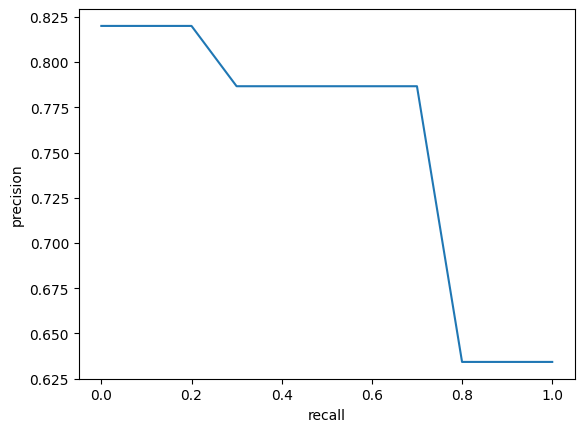

In [18]:
interpolated_precision_list = []
sample_queries = query_list[0:5]
sample_relevants = relevant_list[0:5]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = cosine_score.compute_rankings(query, k_top=10)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

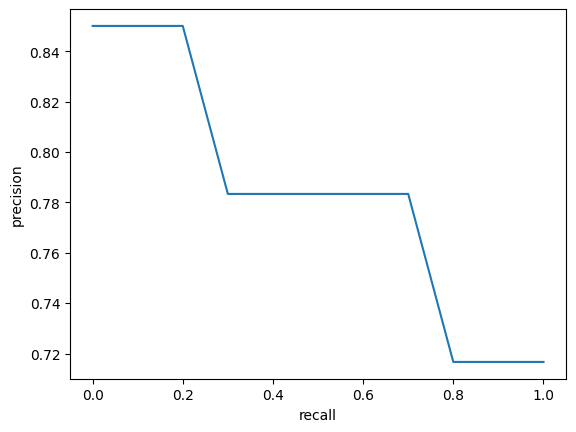

In [19]:
interpolated_precision_list = []
sample_queries = query_list[0:5]
sample_relevants = relevant_list[0:5]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = okapi_bm25.compute_rankings(query, k_top=10, k1=1.5, k3=1.5, b=0.75)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

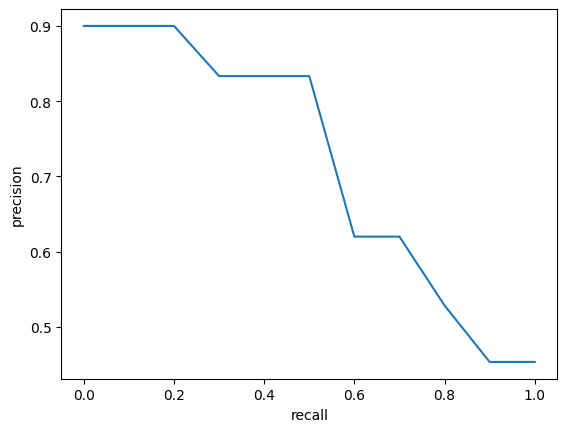

In [20]:
interpolated_precision_list = []
sample_queries = query_list[0:5]
sample_relevants = relevant_list[0:5]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = okapi_bm25.compute_rankings(query, k_top=10, k1=1.5, k3=1.5, b=0.75, method='long')
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

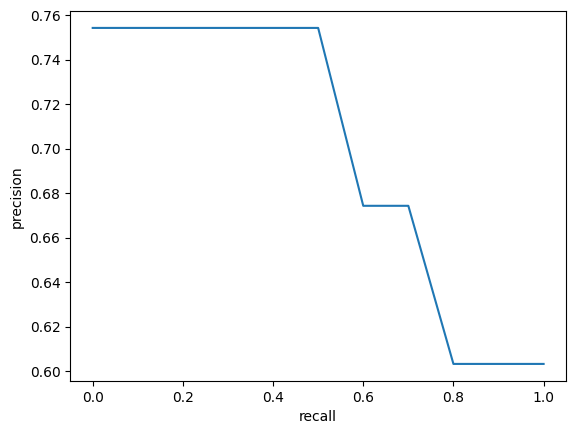

In [21]:
interpolated_precision_list = []
sample_queries = query_list[0:5]
sample_relevants = relevant_list[0:5]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = language_model.compute_rankings(query, k_top=10, lambd=0.9)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

s
همانطور که ملاحظه می کنیم، عملکرد مدل okapi با length از دو مدل دیگر برای پنج کوئری اول بهتر است. همچنین بین دو متود okapi نیز متودی که دارای پارامتر length است بهتر عمل میکند. در مقایسه cosine score و language model نیز همانطور که ملاحظه می شود، cosine score دقت بیشتری داشته است.

#### میخواهیم سیستممان را برای 75 کوئری اول با متود های مختلف تست کنیم و نتیجه را ببینیم:

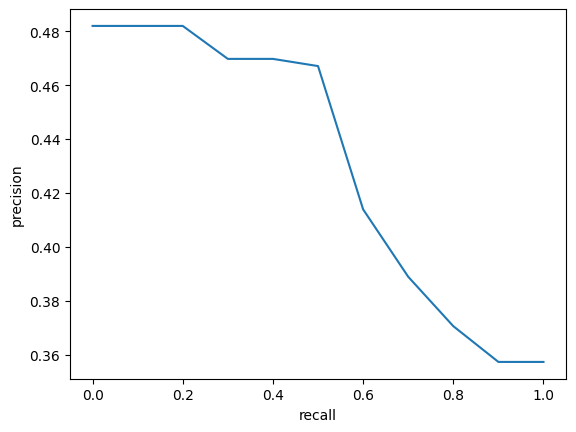

In [22]:
interpolated_precision_list = []
sample_queries = query_list[0:75]
sample_relevants = relevant_list[0:75]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = cosine_score.compute_rankings(query, k_top=10)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

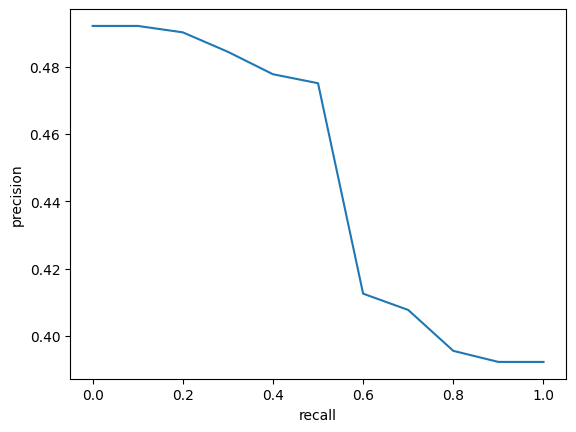

In [23]:
interpolated_precision_list = []
sample_queries = query_list[0:75]
sample_relevants = relevant_list[0:75]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = okapi_bm25.compute_rankings(query, k_top=10, k1=1.5, k3=1.5, b=0.75)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

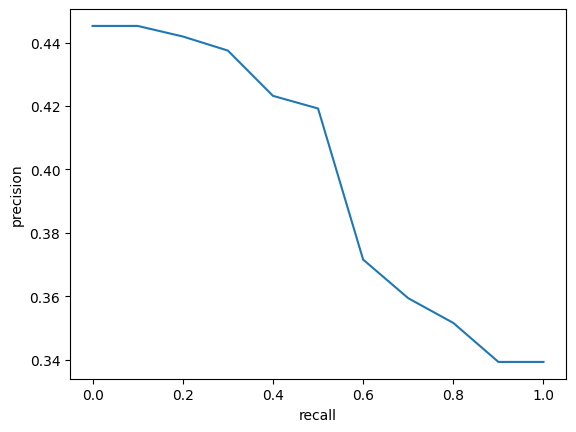

In [24]:
interpolated_precision_list = []
sample_queries = query_list[0:75]
sample_relevants = relevant_list[0:75]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = okapi_bm25.compute_rankings(query, k_top=10, k1=1.5, k3=1.5, b=0.75, method='long')
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

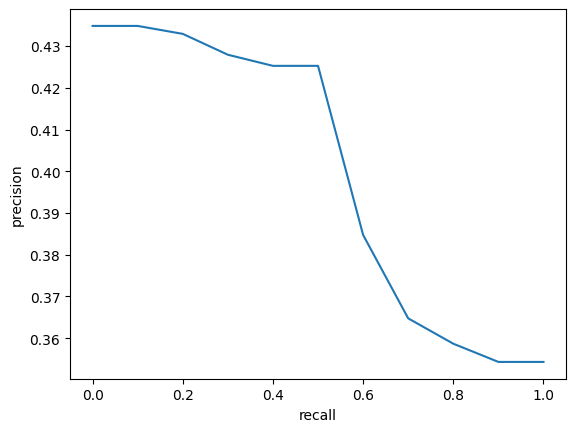

In [25]:
interpolated_precision_list = []
sample_queries = query_list[0:75]
sample_relevants = relevant_list[0:75]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = language_model.compute_rankings(query, k_top=10, lambd=0.9)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

s
در این قسمت نیز میبینم که هر چند عملکرد cosine score نیز خوب است، اما بهترین عملکرد با اختلاف کم برای okapi است و langugage model با اختلاف کمی از همه عملکرد ضعیف تری داشته است.

#### میخواهیم سیستممان را برای 150 کوئری اول با متود های مختلف تست کنیم و نتیجه را ببینیم:


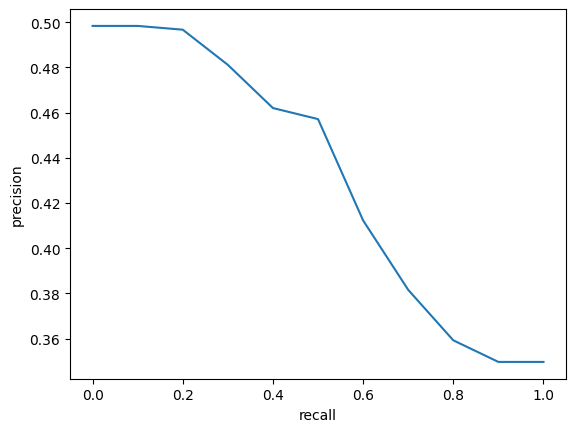

In [26]:
interpolated_precision_list = []
sample_queries = query_list[0:150]
sample_relevants = relevant_list[0:150]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = cosine_score.compute_rankings(query, k_top=10)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

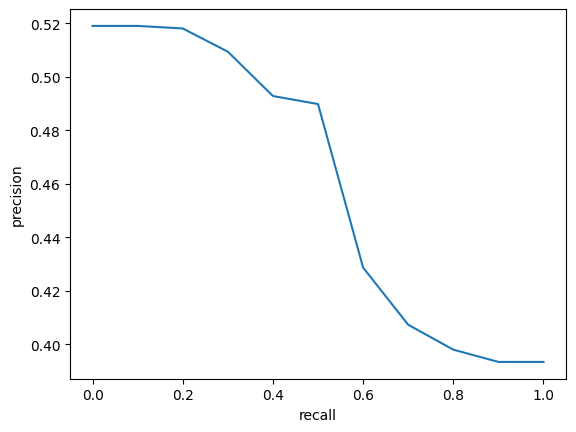

In [27]:
interpolated_precision_list = []
sample_queries = query_list[0:150]
sample_relevants = relevant_list[0:150]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = okapi_bm25.compute_rankings(query, k_top=10, k1=1.5, k3=1.5, b=0.75)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

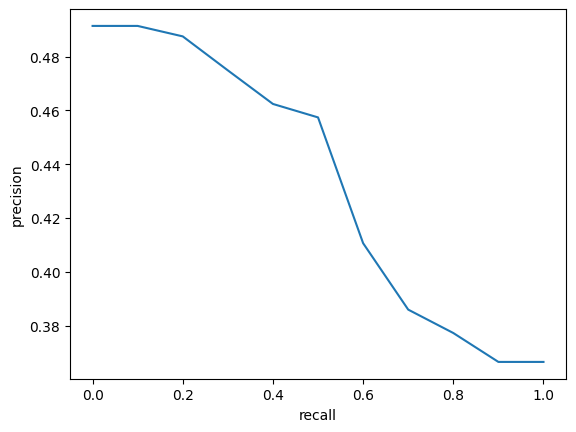

In [28]:
interpolated_precision_list = []
sample_queries = query_list[0:150]
sample_relevants = relevant_list[0:150]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = okapi_bm25.compute_rankings(query, k_top=10, k1=1.5, k3=1.5, b=0.75, method='long')
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

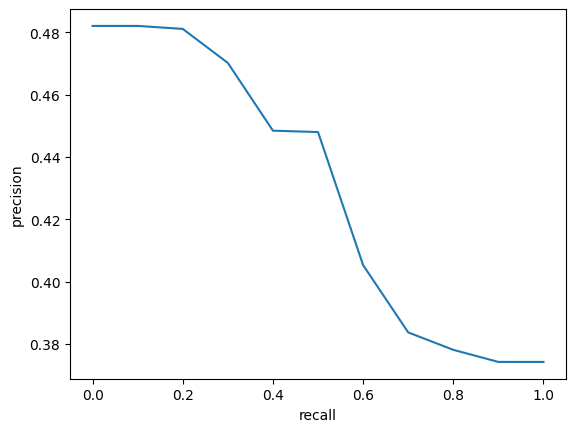

In [29]:
interpolated_precision_list = []
sample_queries = query_list[0:150]
sample_relevants = relevant_list[0:150]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = language_model.compute_rankings(query, k_top=10, lambd=0.9)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

s
در این حالت نیز مشابه حالت های قبلی مدل okapi بهترین عملکرد را در کنار cosine score دارا است. مجددا نیز language model مان نیز با اختلاف خیلی کمی عملکرد کمتری دارد.

#### حال میخواهیم سیستممان را روی تمام کوئری ها یعنی برای ۲۲۵ کوئری اول با متود های مختلف تست کنیم و نتیجه را ببینیم:


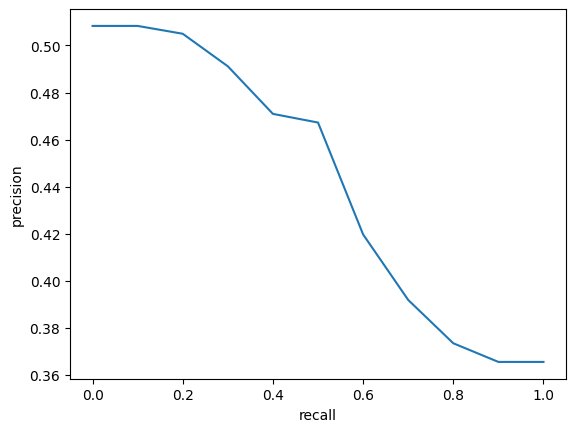

In [30]:
interpolated_precision_list = []
sample_queries = query_list[0:225]
sample_relevants = relevant_list[0:225]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = cosine_score.compute_rankings(query, k_top=10)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

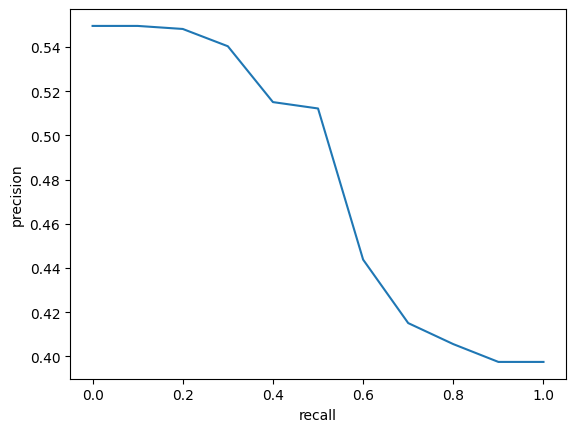

In [31]:
interpolated_precision_list = []
sample_queries = query_list[0:225]
sample_relevants = relevant_list[0:225]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = okapi_bm25.compute_rankings(query, k_top=10, k1=1.5, k3=1.5, b=0.75)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

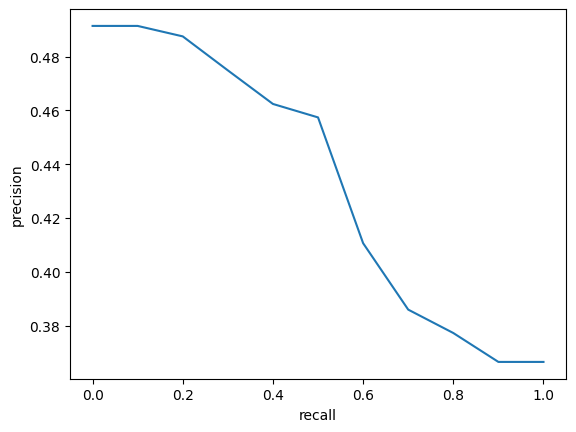

In [32]:
interpolated_precision_list = []
sample_queries = query_list[0:150]
sample_relevants = relevant_list[0:150]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = okapi_bm25.compute_rankings(query, k_top=10, k1=1.5, k3=1.5, b=0.75, method='long')
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

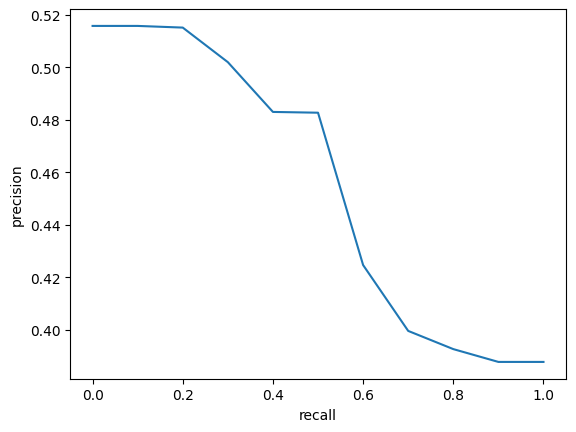

In [33]:
interpolated_precision_list = []
sample_queries = query_list[0:225]
sample_relevants = relevant_list[0:225]
for i,query in enumerate(sample_queries):
    # curr_results = mapping_model_func[model_name](query=query, k_top=k_top, **model_param)
    sample_results = language_model.compute_rankings(query, k_top=10, lambd=0.9)
    curr_interpolated_precision = eval_11_point_interpolation(y_orig=sample_relevants[i], predicted=[doc[1] for doc in sample_results])
    interpolated_precision_list.append(curr_interpolated_precision)
recall = [i*0.1 for i in range(11)]
mean_average_precision = np.array(interpolated_precision_list).sum(axis=0)/len(sample_queries)

plt.plot(recall, mean_average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

s
در تست اخر که تمام کوئری ها را روی مدلمان تست کردیم، ملاحظه نمودیم که مدل okapi دارای بالاترین و بهترین دقت میباشد. بعد از آن نیز مدل cosine score و در نهایت مدل language model به ترتیب دارای بهترین عملکرد های بعدی هستند.